# Fast Gradient Sign Method (FGSM) and PGD using Cleverhans

#### Easily implement an FGSM attack on a model using Cleverhans and Tensorflow 2.0
>
Checkout Cleverhans on Github [here](https://www.github.com/tensorflow/cleverhans).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q tensorflow==2.0.1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/CNOCycle/cleverhans.git@feature/tf2.x
import os, re, time, json
import cleverhans
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import torch as ch

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.1 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0)
ERROR: No matching distribution found for tensorflow==2.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/CNOCycle/cleverhans.git (to revision feature/tf2.x) to /tmp/pip-req-build-nan4l7bp
  Running command git clone --filter=blob:none --quiet https://github.com/CNOCycle/cleverhans.git /tmp/pip-req-build-nan4l7bp
  Running command git checkout -b featu

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.



Tensorflow Version: 2.9.2
Cleverhans Version: 3.0.1-4f6bf54f63245e74e916ddde75918c0a
GPU Available:  False


### **Run** these cells only if you want to attack the cifar model:

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
training_images_n = X_train / 255.0
training_labels_n = y_train
testing_images_n = X_test / 255.0
testing_labels_n = y_test

170498071/170498071 [==============================] - 2s 0us/step


robust only

In [4]:
train_data = ch.cat(ch.load(os.path.join( f"drive/MyDrive/CIFAR_ims")))
train_labels = ch.cat(ch.load(os.path.join( f"drive/MyDrive/CIFAR_lab")))
train_data.shape

torch.Size([50000, 3, 32, 32])

In [5]:
train_images = train_data.numpy()
training_images_r = train_images.transpose([0, 2, 3, 1])
training_labels_r = train_labels.numpy()

In [6]:
test_data = np.load('drive/MyDrive/trob5.npy')
test_labels = np.load('drive/MyDrive/trob.l5.npy')
test_label = np.load('drive/MyDrive/trob.l5.npy')
test_data.shape

(10000, 3, 32, 32)

In [7]:
i=0
t=9990
for j in range(1000):
  test_labels[i:i+10]=test_label[i+t:i+t+10]
  t=t-20
  i=i+10

In [8]:
testing_images_r = test_data.transpose([0, 2, 3, 1])
testing_labels_r = test_labels

c

In [9]:
num_classes = 10

model_n = tf.keras.models.Sequential()

# Add layers
model_n.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model_n.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_n.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_n.add(tf.keras.layers.Dropout(0.25))

# Layer
model_n.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_n.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_n.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_n.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_n.add(tf.keras.layers.Dropout(0.25))

# Layer
model_n.add(tf.keras.layers.Flatten())
model_n.add(tf.keras.layers.Dense(1024, activation='relu'))
model_n.add(tf.keras.layers.Dropout(0.5))
model_n.add(tf.keras.layers.Dense(10, activation='softmax'))
    
# Train the model
checkpoint_path = "training_n/cp1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

os.listdir(checkpoint_dir)
model_n.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_n.load_weights(checkpoint_path)

test_loss, test_acc = model_n.evaluate(testing_images_n, testing_labels_n)

print('Test accuracy:', test_acc)

313/313 [==============================] - 14s 43ms/step - loss: 2.3293 - accuracy: 0.6200
Test accuracy: 0.6200000047683716


In [10]:
num_classes = 10

model_r = tf.keras.models.Sequential()

# Add layers
model_r.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model_r.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_r.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_r.add(tf.keras.layers.Dropout(0.25))

# Layer
model_r.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_r.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_r.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_r.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_r.add(tf.keras.layers.Dropout(0.25))

# Layer
model_r.add(tf.keras.layers.Flatten())
model_r.add(tf.keras.layers.Dense(1024, activation='relu'))
model_r.add(tf.keras.layers.Dropout(0.5))
model_r.add(tf.keras.layers.Dense(10, activation='softmax'))
    
# Train the model

checkpoint_path = "training_r/cp1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.listdir(checkpoint_dir)
model_r.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_r.load_weights(checkpoint_path)

test_loss, test_acc = model_r.evaluate(testing_images_n, testing_labels_n)

print('Test accuracy:', test_acc)

313/313 [==============================] - 11s 33ms/step - loss: 3.3151 - accuracy: 0.5548
Test accuracy: 0.5547999739646912


In [11]:
# Import the attack
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model_n = tf.keras.Model(model_n.input,model_n.layers[-1].output)
logits_model_r = tf.keras.Model(model_r.input,model_r.layers[-1].output)

In [12]:
from cleverhans.future.tf2.attacks import projected_gradient_descent

### Choose a random image to attack from the test set



In [13]:
import time

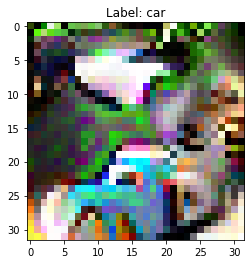

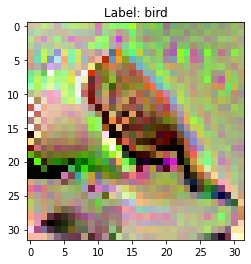

In [14]:
  for j in range (2):
    random_index = np.random.randint(testing_images_r.shape[0])
    original_image = testing_images_r[random_index]
    original_image = tf.convert_to_tensor(original_image.reshape((1,32,32, 3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    
    original_label = testing_labels_r[random_index]
    original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

    #Show the image
    plt.Figure()

    plt.grid(False)
    plt.imshow(np.reshape(original_image, (32,32,3)))
    plt.title("Label: {}".format(classes[original_label[0]]))
    plt.show()


### Non-targeted pgd attack


normal train

In [15]:
i=0
for j in range (1000):

  epsilon = 0.5
  random_index = np.random.randint(training_images_n.shape[0])
  original_image = training_images_n[random_index].astype('float32')
  original_image = tf.convert_to_tensor(original_image.reshape((1,32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    
  original_label = training_labels_n[random_index]
  original_label = np.reshape(original_label, (1,)) # Give label proper shape and type for cleverhans

  adv_example_untargeted_label1 =  projected_gradient_descent(logits_model_n, original_image, epsilon, 0.01, 250, 2, targeted=False)

  adv_example_untargeted_label1_pred = model_r.predict(adv_example_untargeted_label1)

  if np.argmax(adv_example_untargeted_label1_pred) != original_label[0]:
    i = i+1
print (i)

1/1 [==============================] - 0s 20ms/step
480


normal test

In [16]:
i=0
for j in range (1000):

  epsilon = 0.5
  random_index = np.random.randint(testing_images_n.shape[0])
  original_image = testing_images_n[random_index].astype('float32')
  original_image = tf.convert_to_tensor(original_image.reshape((1,32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    
  original_label = testing_labels_n[random_index]
  original_label = np.reshape(original_label, (1,)) # Give label proper shape and type for cleverhans

  adv_example_untargeted_label1 =  projected_gradient_descent(logits_model_n, original_image, epsilon, 0.01, 250, 2, targeted=False)

  adv_example_untargeted_label1_pred = model_r.predict(adv_example_untargeted_label1)

  if np.argmax(adv_example_untargeted_label1_pred) != original_label[0]:
    i = i+1
print (i)

1/1 [==============================] - 0s 21ms/step
476


robust train

In [17]:
i=0
for j in range (1000):

  epsilon = 0.5
  random_index = np.random.randint(training_images_r.shape[0])
  original_image = training_images_r[random_index].astype('float32')
  original_image = tf.convert_to_tensor(original_image.reshape((1,32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    
  original_label = training_labels_r[random_index]
  original_label = np.reshape(original_label, (1,)) # Give label proper shape and type for cleverhans

  adv_example_untargeted_label1 =  projected_gradient_descent(logits_model_n, original_image, epsilon, 0.01, 250, 2, targeted=False)

  adv_example_untargeted_label1_pred = model_r.predict(adv_example_untargeted_label1)

  if np.argmax(adv_example_untargeted_label1_pred) != original_label[0]:
    i = i+1
print (i)

1/1 [==============================] - 0s 21ms/step
211


robust test

In [18]:
i=0
for j in range (1000):

  epsilon = 0.5
  random_index = np.random.randint(testing_images_r.shape[0])
  original_image = testing_images_r[random_index].astype('float32')
  original_image = tf.convert_to_tensor(original_image.reshape((1,32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    
  original_label = testing_labels_r[random_index]
  original_label = np.reshape(original_label, (1,)) # Give label proper shape and type for cleverhans

  adv_example_untargeted_label1 =  projected_gradient_descent(logits_model_n, original_image, epsilon, 0.01, 250, 2, targeted=False)

  adv_example_untargeted_label1_pred = model_r.predict(adv_example_untargeted_label1)

  if np.argmax(adv_example_untargeted_label1_pred) != original_label[0]:
    i = i+1
print (i)

1/1 [==============================] - 0s 19ms/step
435


In [ ]:
i=0
for j in range (100):

  epsilon = 0.5
  random_index = np.random.randint(train_images.shape[0])
  original_image = train_images[random_index].astype('float32')
  original_image = tf.convert_to_tensor(original_image.reshape((1,32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    
  original_label = train_labels[random_index]
  original_label = np.reshape(original_label, (1,)) # Give label proper shape and type for cleverhans

  adv_example_untargeted_label1 =  projected_gradient_descent(logits_model, original_image, epsilon, 0.01, 250, 2, targeted=False)

  adv_example_untargeted_label1_pred = model.predict(adv_example_untargeted_label1)

  if np.argmax(adv_example_untargeted_label1_pred) != original_label[0]:
    i = i+1
print (i)

NameError: ignored

In [ ]:
i=0
for j in range (1000):

  epsilon = 0.5
  random_index = np.random.randint(train_images.shape[0])
  original_image = train_images[random_index].astype('float32')
  original_image = tf.convert_to_tensor(original_image.reshape((1,32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    
  original_label = train_labels[random_index]
  original_label = np.reshape(original_label, (1,)) # Give label proper shape and type for cleverhans

  adv_example_untargeted_label1 =  projected_gradient_descent(logits_model, original_image, epsilon, 0.01, 250, 2, targeted=False)

  adv_example_untargeted_label1_pred = model.predict(adv_example_untargeted_label1)

  if np.argmax(adv_example_untargeted_label1_pred) != original_label[0]:
    i = i+1
print (i)

In [ ]:
i=0
for j in range (100):

  epsilon = 0.25
  random_index = np.random.randint(train_images.shape[0])
  original_image = train_images[random_index].astype('float32')
  original_image = tf.convert_to_tensor(original_image.reshape((1,32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    
  original_label = training_labels[random_index]
  original_label = np.reshape(original_label, (1,)) # Give label proper shape and type for cleverhans

  adv_example_untargeted_label1 =  projected_gradient_descent(logits_model, original_image, epsilon, 0.01, 250, 2, targeted=False)

  adv_example_untargeted_label1_pred = model.predict(adv_example_untargeted_label1)

  if np.argmax(adv_example_untargeted_label1_pred) != original_label[0]:
    i = i+1
print (i)

In [ ]:
i=0
for j in range (100):

  epsilon = 0.25
  random_index = np.random.randint(test_images.shape[0])
  original_image = test_images[random_index].astype('float32')
  original_image = tf.convert_to_tensor(original_image.reshape((1,32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    
  original_label = test_labels[random_index]
  original_label = np.reshape(original_label, (1,)) # Give label proper shape and type for cleverhans

  adv_example_untargeted_label1 =  projected_gradient_descent(logits_model, original_image, epsilon, 0.01, 250, 2, targeted=False)

  adv_example_untargeted_label1_pred = model.predict(adv_example_untargeted_label1)

  if np.argmax(adv_example_untargeted_label1_pred) != original_label[0]:
    i = i+1
print (i)

In [ ]:
i=0
for j in range (100):

  epsilon = 0.5
  random_index = np.random.randint(train_images.shape[0])
  original_image = train_images[random_index].astype('float32')
  original_image = tf.convert_to_tensor(original_image.reshape((1,32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    
  original_label = train_labels[random_index]
  original_label = np.reshape(original_label, (1,)) # Give label proper shape and type for cleverhans

  adv_example_untargeted_label1 =  projected_gradient_descent(logits_model, original_image, epsilon, 0.01, 250, 2, targeted=False)

  adv_example_untargeted_label1_pred = model.predict(adv_example_untargeted_label1)

  if np.argmax(adv_example_untargeted_label1_pred) != original_label[0]:
    i = i+1
print (i)

In [ ]:
i=0
for j in range (100):

  epsilon = 0.5
  random_index = np.random.randint(train_images.shape[0])
  original_image = test_images[random_index].astype('float32')
  original_image = tf.convert_to_tensor(original_image.reshape((1,32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    
  original_label = test_labels[random_index]
  original_label = np.reshape(original_label, (1,)) # Give label proper shape and type for cleverhans

  adv_example_untargeted_label1 =  projected_gradient_descent(logits_model, original_image, epsilon, 0.01, 250, 2, targeted=False)

  adv_example_untargeted_label1_pred = model.predict(adv_example_untargeted_label1)

  if np.argmax(adv_example_untargeted_label1_pred) != original_label[0]:
    i = i+1
print (i)

d

In [ ]:
i=0
for j in range (100):

  epsilon = 0.25
  random_index = np.random.randint(train_images.shape[0])
  original_image = train_images[random_index].astype('float32')
  original_image = tf.convert_to_tensor(original_image.reshape((1,32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    
  original_label = train_labels[random_index].astype('float32')
  original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

  adv_example_untargeted_label1 =  projected_gradient_descent(logits_model, original_image, epsilon, 0.01, 250, 2, targeted=False)

  adv_example_untargeted_label1_pred = model.predict(adv_example_untargeted_label1)

  if np.argmax(adv_example_untargeted_label1_pred) != original_label[0]:
    i = i+1
print (i)

In [ ]:
for j in range (100):
  start_time = time.time()

  epsilon = 0.25
  
  random_index = np.random.randint(test_images.shape[0])
  original_image = test_images[random_index]
  original_image = tf.convert_to_tensor(original_image.reshape((1,32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    
  original_label = test_labels[random_index]
  original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

  adv_example_untargeted_label1 =  projected_gradient_descent(logits_model, original_image, epsilon, 0.01, 2500, 2, targeted=False)

  adv_example_untargeted_label1_pred = model.predict(adv_example_untargeted_label1)

  print("--- %s seconds ---" % (time.time() - start_time))


  #Show the image
  plt.figure()
  plt.grid(False)

  plt.imshow(np.reshape(adv_example_untargeted_label1, (32,32,3)))
  plt.title("Model Prediction: {}".format(classes[np.argmax(adv_example_untargeted_label1_pred)]))
  plt.xlabel("Original Label: {}".format(classes[original_label[0]]))

  plt.show()

### Non-targeted FGSM attack


In [ ]:
start_time = time.time()

epsilon = 0.1

adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, 2, targeted=False)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

print("--- %s seconds ---" % (time.time() - start_time))

for i in range (5):
  #Show the image
  plt.figure()
  plt.grid(False)

  plt.imshow(np.reshape(adv_example_untargeted_label, (32,32,3)))
  plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
  plt.xlabel("Original Label: {}".format(original_label[0]))

  plt.show()

In [ ]:
start_time = time.time()

epsilon = 0.1

adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

print("--- %s seconds ---" % (time.time() - start_time))


for i in range (5):

  #Show the image
  plt.figure()
  plt.grid(False)

  plt.imshow(np.reshape(adv_example_untargeted_label, (32,32,3)))
  plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
  plt.xlabel("Original Label: {}".format(original_label[0]))

  plt.show()

### Targeted pgd Attack

In [ ]:
start_time = time.time()

epsilon = 1
# The target value may have to be changed to work, some images are more easily missclassified as different labels
target = 2
target_label = np.reshape(target, (1,)).astype('int64') # Give target label proper size and dtype to feed through

adv_example_targeted_label1 = projected_gradient_descent(logits_model, original_image, epsilon, 0.01, 40, 2, y=target_label, targeted=True)

adv_example_targeted_label1_pred = model.predict(adv_example_targeted_label1)

print("--- %s seconds ---" % (time.time() - start_time))

for i in range (5):

  #Show the image
  plt.figure()
  plt.grid(False)

  plt.imshow(np.reshape(adv_example_targeted_label1, (32,32,3)))
  plt.title("Model Prediction: {}".format(np.argmax(adv_example_targeted_label1_pred)))
  plt.xlabel("Original Label: {}".format(original_label[0]))

  plt.show()

### Targeted FGSM Attack

### Other Docs
>
Find more tutorials for Cleverhans [here](https://github.com/tensorflow/cleverhans/tree/master/tutorials/future/tf2).